# Homework 7 (4 points)

In this assignment we're going to tackle finding CpG islands in a simulated genome. We're implementing the Viterbi decoding algorithm for finding the most likely path of CpG and non-CpG islands in our dataset. For those who are curious you can implement your own forward-backwards algorithm to optimize these parameters, but for now you're given the parameters that should be effective at finding these islands.

### Transition probabilities between CpG bases

We'll use the following CpG model from Durbin's book:

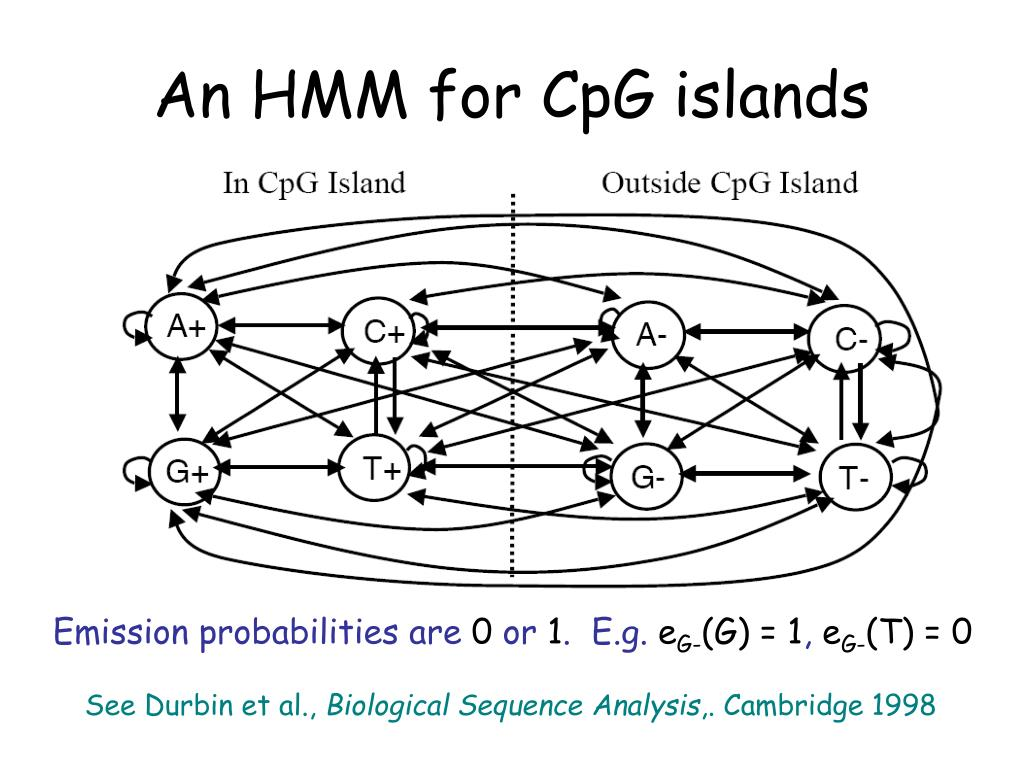

For this model we'll use the transisiton probabilities they describe in the book, which are approximately: 

|_ |     A+|     C+|     G+|     T+|     A-|     C-|     G-|     T-|
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|A+| 0.1793| 0.2729| 0.4243| 0.1195|  0.001|  0.001|  0.001|  0.001|
|C+| 0.1701| 0.3662| 0.2726| 0.1871|  0.001|  0.001|  0.001|  0.001|
|G+| 0.1604| 0.3376| 0.3735| 0.1245|  0.001|  0.001|  0.001|  0.001|
|T+| 0.0787| 0.3536| 0.3825| 0.1813|  0.001|  0.001|  0.001|  0.001|
|A-| 0.0001| 0.0001| 0.0001| 0.0001| 0.2999| 0.2049| 0.2849| 0.2099|
|C-| 0.0001| 0.0001| 0.0001| 0.0001| 0.3219| 0.2979|  0.078| 0.3019|
|G-| 0.0001| 0.0001| 0.0001| 0.0001| 0.2479| 0.2459| 0.2979| 0.2079|
|T-| 0.0001| 0.0001| 0.0001| 0.0001| 0.1769| 0.2389| 0.2919| 0.2919|

Transisiton probabilities between any CpG and non-CpG bases are rare and not equal in both directions. For instance:

- an A+ (A in a CpG) to a T- (T in a non-CpG) is ```1/1,000```, whereas 
- the opposite from T- to A+ happens in about ```1/10,000``` bases.



In [ ]:
import numpy as np

In [ ]:
# our transition matrix
transitions = np.array([[0.180 , 0.274 , 0.426 , 0.120 , 0.001 , 0.001 , 0.001 , 0.001], 
[0.171 , 0.368 , 0.274 , 0.188 , 0.001 , 0.001 , 0.001 , 0.001], 
[0.161 , 0.339 , 0.375 , 0.125 , 0.001 , 0.001 , 0.001 , 0.001], 
[0.079 , 0.355 , 0.384 , 0.182 , 0.001 , 0.001 , 0.001 , 0.001], 
[0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.300 , 0.205 , 0.285 , 0.210], 
[0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.322 , 0.298 , 0.078 , 0.302], 
[0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.248 , 0.246 , 0.298 , 0.208], 
[0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.177 , 0.239 , 0.292 , 0.292]])

# we have to normalize as we've added the CpG to non-CpG transitions in after the fact
row_sums_transitions = transitions.sum(axis=1)
transitions = transitions / row_sums_transitions[:, np.newaxis]

transitions

### Emission states

One nice aspect of splitting up the model into hidden states for each CpG state (+ and -) and nucleotide (A,C,G, and T) is that our emission values can be very simple. For any plus (+, CpG) or minus (-, non-CpG) the emission probabilties are just 1 when the base matches, 0 when it doesn't.

|_ |     A|     C|     G|     T|
| --- | --- | --- | --- | --- |
|A+|     1|     0|     0|     0|
|C+|     0|     1|     0|     0|
|G+|     0|     0|     1|     0|
|T+|     0|     0|     0|     1|
|A-|     1|     0|     0|     0|
|C-|     0|     1|     0|     0|
|G-|     0|     0|     1|     0|
|T-|     0|     0|     0|     1|

In [ ]:
emissions = np.array([[1,0,0,0],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1],
             [1,0,0,0],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1]])

emissions

### Start probabilities

The last thing we'll need is a set of starting probabilties. Given our transition probabilities it's safe to assume we're much more likely to be in a non-CpG region than in a CpG region. Our starting probabilties will reflect this:

| _ | CpG | non-CpG | 
| --- | --- | --- |
| start | 0.1 | 0.9 |

Given we have individual letter for our states, it'll have to be enumerated out for each nucleotide:

| _ |  A+|     C+|     G+|     T+|     A-|     C-|     G-|     T-|
| --- | --- | --- |--- | --- | --- |--- | --- | --- |
| start | 0.1 |0.1 |0.1 |0.1 | 0.9 |0.9 |0.9 |0.9 | 


In [ ]:
start_transitions = np.array([0.1,0.1,0.1,0.1,0.9,0.9,0.9,0.9])

### Nucleotide sequence

Lastly we need to load a fake sequence of nucleotides that have hidden CpG islands:


In [ ]:
fake_nucleotides = open("Fake_CpG_island_sequence_10pct_CpGs.fasta")
header = fake_nucleotides.readline()
fake_nucleotide_string = ""
for line in fake_nucleotides:
    fake_nucleotide_string += line.strip()
    
print("Fake genome length: ",len(fake_nucleotide_string))

# cpg_finder (4 points)

Create a function that uses the Viterbi decoding algorithm to find CpG islands in this fake genome. You should use all the parameters passed to this function, and return a 1D numpy array, the size of the genome, with 0s indicating a non-CpG basepair and 1 indicating a CpG basepair. 

In [ ]:

def cpg_finder(start_transitions,transitions,emissions,sequence):
    '''
    Create a function that uses the Viterbi decoding algorithm to find CpG islands in this fake genome. You 
    should use all the parameters passed to this function, detailed above, and return a 1D numpy array, 
    the size of the genome, with 0s indicating a non-CpG basepair and 1 indicating a CpG basepair. 
    '''
    return states # 1D numpy array return

returned_states = cpg_finder(start_transitions,transitions,emissions,fake_nucleotide_string)


# Compare against the known, generated state 

We created this sequencing data using the same model parameters. You can see how well your ```returned_states``` detected the CpG islands. The accuracy is very dependent on:
- getting your code working
- the power of the two distributions of nucleotides to correctly separate the two hidden states

Using these realistic parameters we're able to get a pretty good accuracy, though other metrics like our positive predictive value is much lower. We made a big assumption in setting up our transitions values, how could we fix this? (you don't have to answer this here).




In [ ]:
confusion_matrix = np.zeros((2,2))

truth_array = [int(x) for x in open("known_values_for_Fake_CpG_island_sequence_10pct_CpGs.txt").readline().strip().split(",")]

for known,called in zip(truth_array,returned_states):
    confusion_matrix[known,called] += 1
    
def pretty_print(seq_A, seq_B, dp_matrix,pad=15):
    max_str_length = max(len(seq_A),len(seq_B))
    print(" ".rjust(pad) + "".join([letter_in_B.rjust(pad) for letter_in_B in seq_B]))

    for row_label, row in zip(seq_A, dp_matrix):
        print(row_label.rjust(pad) + "".join([str(mat_value).rjust(pad) for mat_value in row]))
        
pretty_print(["Known non-CpG","Known CpG"], ["Non-CpG","CpG"], confusion_matrix)

print("\naccuracy : " + str((confusion_matrix[0,0]+confusion_matrix[1,1])/confusion_matrix.sum()))
